In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import sklearn
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

import tensorflow as tf
import keras
from keras.layers import Input, LSTM, Dense, Dropout, Flatten

In [2]:
# Define how many time steps will be used in observation and prediction
n_past = 24 # The last day of data
n_future = 24 # The next day of data
n_features = 3

In [3]:
# Define a function to split the series using a sliding window
def split_series(series, n_past=n_past, n_future=n_future, offset=0):
    X, y = list(), list()
    for i in range(int(len(series)/n_past)-1):
        X.append(series[i*n_past : i*n_past + n_past, :])
        y.append(series[offset + i*n_past + n_past : offset + i*n_past + n_past + n_future, :])
    return np.array(X), np.array(y)

In [4]:
# Process and split the data for a site given its filename
def prep_data(filename):
    # Import the data for a single point
    data = pd.read_csv("Data/NOW-23 Great Lakes [2000-2020] 60min/" + filename, index_col=0)

    # Restrict the data to the last 5 years, giving us 4 years of training and 1 year of testing data
    data = data.iloc[int(len(data)*1/4):]

    # Split the data into training and testing samples
    cutoff = int(len(data)*0.8)
    test_data = data[cutoff:]
    data = data[:cutoff]

    # Normalize the testing and training data
    test_data.iloc[:, 6:9], test_norms = normalize(test_data.iloc[:, 6:9], axis=0, norm='max', return_norm=True)
    data.iloc[:, 6:9], train_norms = normalize(data.iloc[:, 6:9], axis=0, norm='max', return_norm=True)

    # Split the data into series for training
    X_train, y_train = split_series(np.array(data.iloc[:, 6:9]), n_future=1, offset=24-1)
    X_test, y_test = split_series(np.array(test_data.iloc[:, 6:9]), n_future=1, offset=24-1)

    # Adjust the expected output to contain only the wind speed
    y_train, y_test = y_train[:, :, 2], y_test[:, :, 2]
    
    return X_train, y_train, X_test, y_test, train_norms, test_norms

In [42]:
# Define the model architecture
def define_model():
    model = keras.models.Sequential()
    model.add(Input(shape=(n_past, n_features)))
    model.add(LSTM(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(8, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dense(1, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.compile(optimizer='adam', loss='mae')
    return model

In [43]:
model = define_model()
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 16)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,425 (5.57 KB)

 Trainable params: 1,425 (5.57 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
i = 1
for filename in os.listdir("Data/NOW-23 Great Lakes [2000-2020] 60min"):
    print(f"Point number {i} of 100")
    i += 1

    model = define_model()
    
    X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data(filename)
    
    model.fit(X_train,y_train,epochs=200,validation_data=(X_test,y_test),batch_size=64)
    # model.save('Data/Models/' + filename[:-4] + '.keras')

Point number 1 of 100
Epoch 1/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1272 - val_loss: 0.1316
Epoch 2/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1146 - val_loss: 0.1250
Epoch 3/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1113 - val_loss: 0.1250
Epoch 4/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1078 - val_loss: 0.1227
Epoch 5/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1069 - val_loss: 0.1271
Epoch 6/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1041 - val_loss: 0.1259
Epoch 7/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1066 - val_loss: 0.1247
Epoch 8/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1039 - val_loss: 0.1247
Epoch 9/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1033 - val_loss: 0.1201
Epoch 10/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1050 - val_loss: 0.1199
Epoch 11/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1017 - val_loss: 0.1210
Epoch 12/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0

KeyboardInterrupt: 

In [77]:
mae, sites = list(), list()

for filename in os.listdir("Data/Models"):

    X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data(filename[:-6] + '.csv')
    model = keras.saving.load_model("Data/Models/" + filename)
    model.compile(optimizer='adam', loss='mae')
    
    predictions = model.predict(X_test)
    mae.append(mean_absolute_error(y_test[:, 0] * test_norms[2], predictions * test_norms[2]))
    sites.append(filename[:-6])
    
df = pd.DataFrame()
df['MAE'] = pd.Series(mae)
df['SiteID'] = pd.Series(sites)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
36/36 ━━━━━━━━━━━━━━━━━━━

'\ndf = pd.DataFrame()\ndf["predictions"] = predictions[:, 0] * test_norms[2]\ndf[\'observed\'] = y_test[:, 0] * test_norms[2]\nplt.plot(df.iloc[:50])\n'

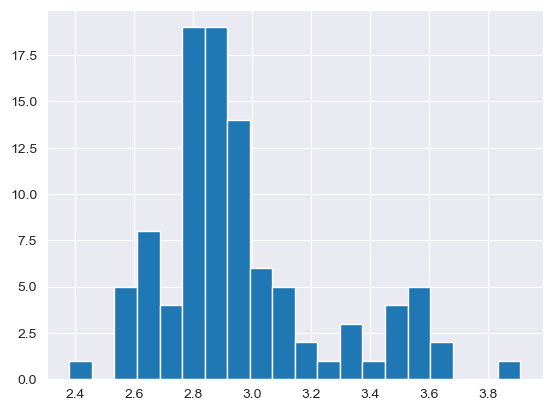

C:\Users\shell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


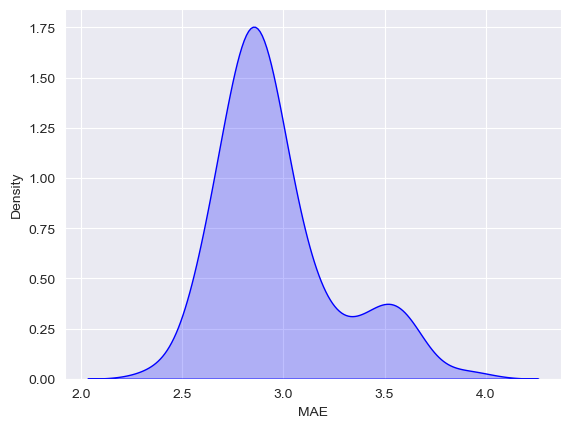

{'whiskers': [<matplotlib.lines.Line2D at 0x202814af810>,
 'caps': [<matplotlib.lines.Line2D at 0x20289c9fb90>,
 'boxes': [<matplotlib.lines.Line2D at 0x202897ffad0>],
 'medians': [<matplotlib.lines.Line2D at 0x20289c9ffd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x20289c9d210>],
 'means': []}

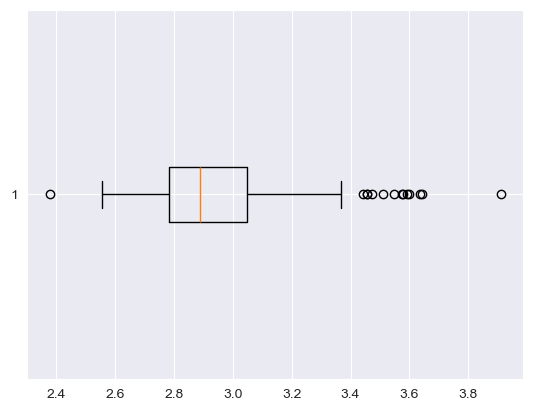

In [82]:
import seaborn as sns

df['MAE'].hist(bins=20)
plt.show()

sns.kdeplot(df['MAE'], color="blue", fill=True)
plt.show()

plt.boxplot(df['MAE'], vert=False)

In [83]:
total = 0
for i in df['MAE']:
    total += i
avg_mae = total/len(df['MAE'])
print(f"Average MAE of the LSTM models over all sites: {avg_mae}")

Average MAE of the LSTM models over all sites: 2.962846114764022


In [84]:
# Finally, we repeat this analysis with a persistence model that uses the wind speed from 24h before as a prediction, demonstrating the superiority of the LSTM model

mae, sites = list(), list()

for filename in os.listdir("Data/Models"):

    X_train, y_train, X_test, y_test, train_norms, test_norms = prep_data(filename[:-6] + '.csv')

    predictions = [x[-1] for x in X_test[:, :, -1]]
    mae.append(mean_absolute_error(y_test[:, 0] * test_norms[2], np.array(predictions) * test_norms[2]))
    sites.append(filename[:-6])

df = pd.DataFrame()
df['MAE'] = pd.Series(mae)
df['SiteID'] = pd.Series(sites)

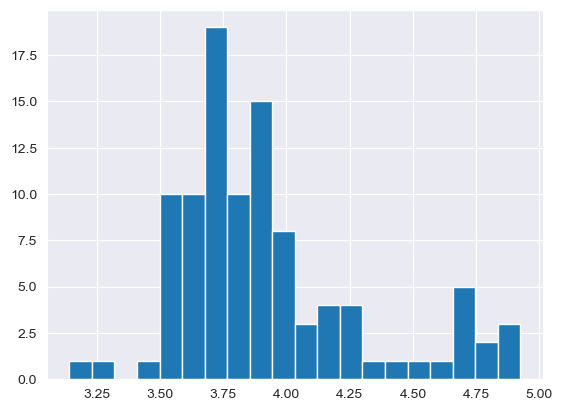

C:\Users\shell\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='MAE', ylabel='Density'>

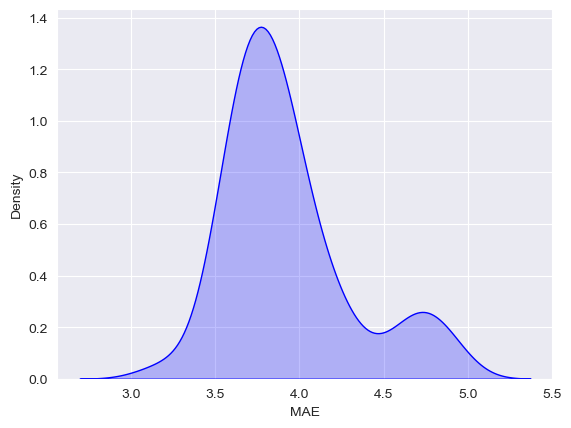

In [85]:
df['MAE'].hist(bins=20)
plt.show()

sns.kdeplot(df['MAE'], color="blue", fill=True)

In [87]:
total = 0
for i in df['MAE']:
    total += i
peristence_avg_mae = total/len(df['MAE'])
print(f"Average MAE of the persistence model: {peristence_avg_mae}")
print(f"The persistence model has a higher MAE by {(peristence_avg_mae/avg_mae - 1) * 100}%")

Average MAE of the persistence model: 3.923012456445994
The persistence model has a higher MAE by 32.40689203861824%


Unsurpisingly, the average MAE of the persistence model is around 32% higher than the average LSTM model MAE over all sites